In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import random

import matplotlib.pyplot as plt
%matplotlib inline

# Set some parameters to get good visuals - style to ggplot and size to 15,10
plt.style.use('ggplot')
import matplotlib.style as style
style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (15, 8)

import seaborn as sns
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

from sklearn import preprocessing
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

In [2]:
data = pd.read_csv('/kaggle/input/ip-data/final_ip_mapped_data.csv')

In [3]:
data.head()

,@timestamp,_id,ip_address
0,"July 8th 2019, 14:43:03.000",XswJ0msBoTGddM7vxMDB,10.1.1.285
1,"July 8th 2019, 14:43:01.000",dKQJ0msB7mP0GwVzvJjz,10.1.2.389
2,"July 8th 2019, 14:42:59.000",CcwJ0msBoTGddM7vtb8y,10.1.1.415
3,"July 8th 2019, 14:42:57.000",bKQJ0msB7mP0GwVzrZdT,10.1.1.79
4,"July 8th 2019, 14:42:55.000",L6QJ0msB7mP0GwVzpZeI,10.1.1.60


# Feature Building

In [4]:
data['@timestamp'] = data['@timestamp'].str.replace(r'(\d{1,2})(st|nd|rd|th)', r'\1', regex=True)

In [6]:
data['@timestamp'] = pd.to_datetime(data['@timestamp'])

In [7]:
data.sort_values(['ip_address', '@timestamp'], inplace=True)

In [8]:
data['shift_time'] = data.groupby(['ip_address'])['@timestamp'].shift(1)

In [9]:
data['time_diff'] = (data['@timestamp'] - data['shift_time']).dt.seconds//60

In [10]:
data['date'] = data['@timestamp'].dt.date

In [11]:
data['dow'] = data['@timestamp'].dt.weekday

In [12]:
data['hour'] = data['@timestamp'].dt.hour

In [13]:
data['is_weekend'] = ((data['dow']==5)|(data['dow']==6)).astype(int)

In [14]:
data['hour_bucket'] = data['hour']//4

In [15]:
data.head(10)

,@timestamp,_id,ip_address,shift_time,time_diff,date,dow,hour,is_weekend,hour_bucket
721473,2019-06-09 00:06:09,DBuOOWsB7mP0GwVzhZ9U,10.1.1.1,NaT,NaN,2019-06-09,6,0,1,0
720483,2019-06-09 01:28:39,bB7aOWsB7mP0GwVzDY5G,10.1.1.1,2019-06-09 00:06:09,82.0,2019-06-09,6,1,1,0
719233,2019-06-09 03:12:49,R0w5OmsBoTGddM7vayZT,10.1.1.1,2019-06-09 01:28:39,104.0,2019-06-09,6,3,1,0
719222,2019-06-09 03:13:45,U0w6OmsBoTGddM7vRi8R,10.1.1.1,2019-06-09 03:12:49,0.0,2019-06-09,6,3,1,0
718875,2019-06-09 03:42:39,z01UOmsBoTGddM7vuzyC,10.1.1.1,2019-06-09 03:13:45,28.0,2019-06-09,6,3,1,0
718730,2019-06-09 03:54:45,x01fOmsBoTGddM7vz6d3,10.1.1.1,2019-06-09 03:42:39,12.0,2019-06-09,6,3,1,0
718240,2019-06-09 04:35:35,nk-FOmsBoTGddM7vLRjb,10.1.1.1,2019-06-09 03:54:45,40.0,2019-06-09,6,4,1,1
717685,2019-06-09 05:21:49,N1CvOmsBoTGddM7vhbSz,10.1.1.1,2019-06-09 04:35:35,46.0,2019-06-09,6,5,1,1
717521,2019-06-09 05:35:29,tlG8OmsBoTGddM7vCDDU,10.1.1.1,2019-06-09 05:21:49,13.0,2019-06-09,6,5,1,1
717169,2019-06-09 06:04:49,uFLWOmsBoTGddM7v4zfT,10.1.1.1,2019-06-09 05:35:29,29.0,2019-06-09,6,6,1,1


# IP Profile Building

In [16]:
ip_col = 'ip_address'

## Counts

In [17]:
ip_counts = data.groupby(ip_col)['@timestamp'].count().reset_index()

In [18]:
ip_counts = ip_counts.rename(columns={'@timestamp':'total_count'})

## Daily counts average

In [19]:
daily_counts = data.groupby([ip_col, 'date'])['@timestamp'].count().reset_index()

In [20]:
daily_counts = daily_counts.rename(columns={'@timestamp':'daily_counts'})

In [21]:
daily_counts_agg = daily_counts.groupby(ip_col).daily_counts.median().reset_index()

In [22]:
daily_counts_agg.head(20)

,ip_address,daily_counts
0,10.1.1.1,40.0
1,10.1.1.100,78.0
2,10.1.1.101,40.0
3,10.1.1.106,35.5
4,10.1.1.109,42.5
5,10.1.1.110,41.0
6,10.1.1.114,37.0
7,10.1.1.118,42.0
8,10.1.1.119,42.0
9,10.1.1.12,40.0


## weekday weekend counts average

In [23]:
weekend_counts = data.groupby([ip_col, 'is_weekend'])['@timestamp'].count().reset_index()

In [24]:
weekend_counts = weekend_counts.rename(columns={'@timestamp':'weekend_counts'})

In [25]:
weekend_counts_agg = weekend_counts.pivot_table(index=ip_col, columns='is_weekend').reset_index([0])

In [26]:
weekend_counts_agg.columns = weekend_counts_agg.columns.droplevel()

In [27]:
weekend_counts_agg.columns = [ip_col, 'week_day', 'weekend']

In [28]:
weekend_counts_agg['is_weekend_ratio'] = weekend_counts_agg['week_day']/ weekend_counts_agg['weekend']

In [29]:
lean_weekend_counts_agg = weekend_counts_agg[[ip_col, 'is_weekend_ratio']]

## avg login time

In [30]:
avg_timedelta_data = data.groupby(ip_col).agg({'time_diff':['mean','max']}).reset_index()

In [31]:
avg_timedelta_data.columns = avg_timedelta_data.columns.droplevel()

In [32]:
avg_timedelta_data.columns = [ip_col, 'td_mean', 'td_max']

In [33]:
avg_timedelta_data.head(10)

,ip_address,td_mean,td_max
0,10.1.1.1,28.999308,362.0
1,10.1.1.100,14.427072,185.0
2,10.1.1.101,28.520492,211.0
3,10.1.1.106,29.771144,319.0
4,10.1.1.109,28.711934,278.0
5,10.1.1.110,28.249831,240.0
6,10.1.1.114,29.827169,300.0
7,10.1.1.118,28.976471,267.0
8,10.1.1.119,29.087561,232.0
9,10.1.1.12,30.152408,250.0


## Full Feature Set

In [34]:
merge_1 = ip_counts.merge(daily_counts_agg, on=ip_col, how='left')

In [35]:
merge_2 = merge_1.merge(lean_weekend_counts_agg, on=ip_col, how='left')

In [36]:
final_data = merge_2.merge(avg_timedelta_data, on=ip_col, how='left')

In [37]:
final_data.head(10)

,ip_address,total_count,daily_counts,is_weekend_ratio,td_mean,td_max
0,10.1.1.1,1446,40.0,2.070064,28.999308,362.0
1,10.1.1.100,2860,78.0,2.177778,14.427072,185.0
2,10.1.1.101,1465,40.0,2.191721,28.520492,211.0
3,10.1.1.106,1408,35.5,2.229358,29.771144,319.0
4,10.1.1.109,1459,42.5,2.206593,28.711934,278.0
5,10.1.1.110,1482,41.0,2.242888,28.249831,240.0
6,10.1.1.114,1407,37.0,2.140625,29.827169,300.0
7,10.1.1.118,1446,42.0,2.308924,28.976471,267.0
8,10.1.1.119,1440,42.0,2.257919,29.087561,232.0
9,10.1.1.12,1392,40.0,2.200000,30.152408,250.0


In [38]:
ip_map = final_data[ip_col].to_dict()

In [39]:
RANDOM_STATE = 123

## KMEANS

In [40]:
final_data.columns

Index(['ip_address', 'total_count', 'daily_counts', 'is_weekend_ratio',
       'td_mean', 'td_max'],
      dtype='object')

In [41]:
feature_cols = ['total_count', 'daily_counts', 'is_weekend_ratio', 'td_mean', 'td_max']

In [42]:
data_new = final_data[feature_cols]

In [43]:
min_max_scaler = preprocessing.MinMaxScaler()

In [44]:
np_scaled = min_max_scaler.fit_transform(data_new)
data_new = pd.DataFrame(np_scaled, columns=feature_cols)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

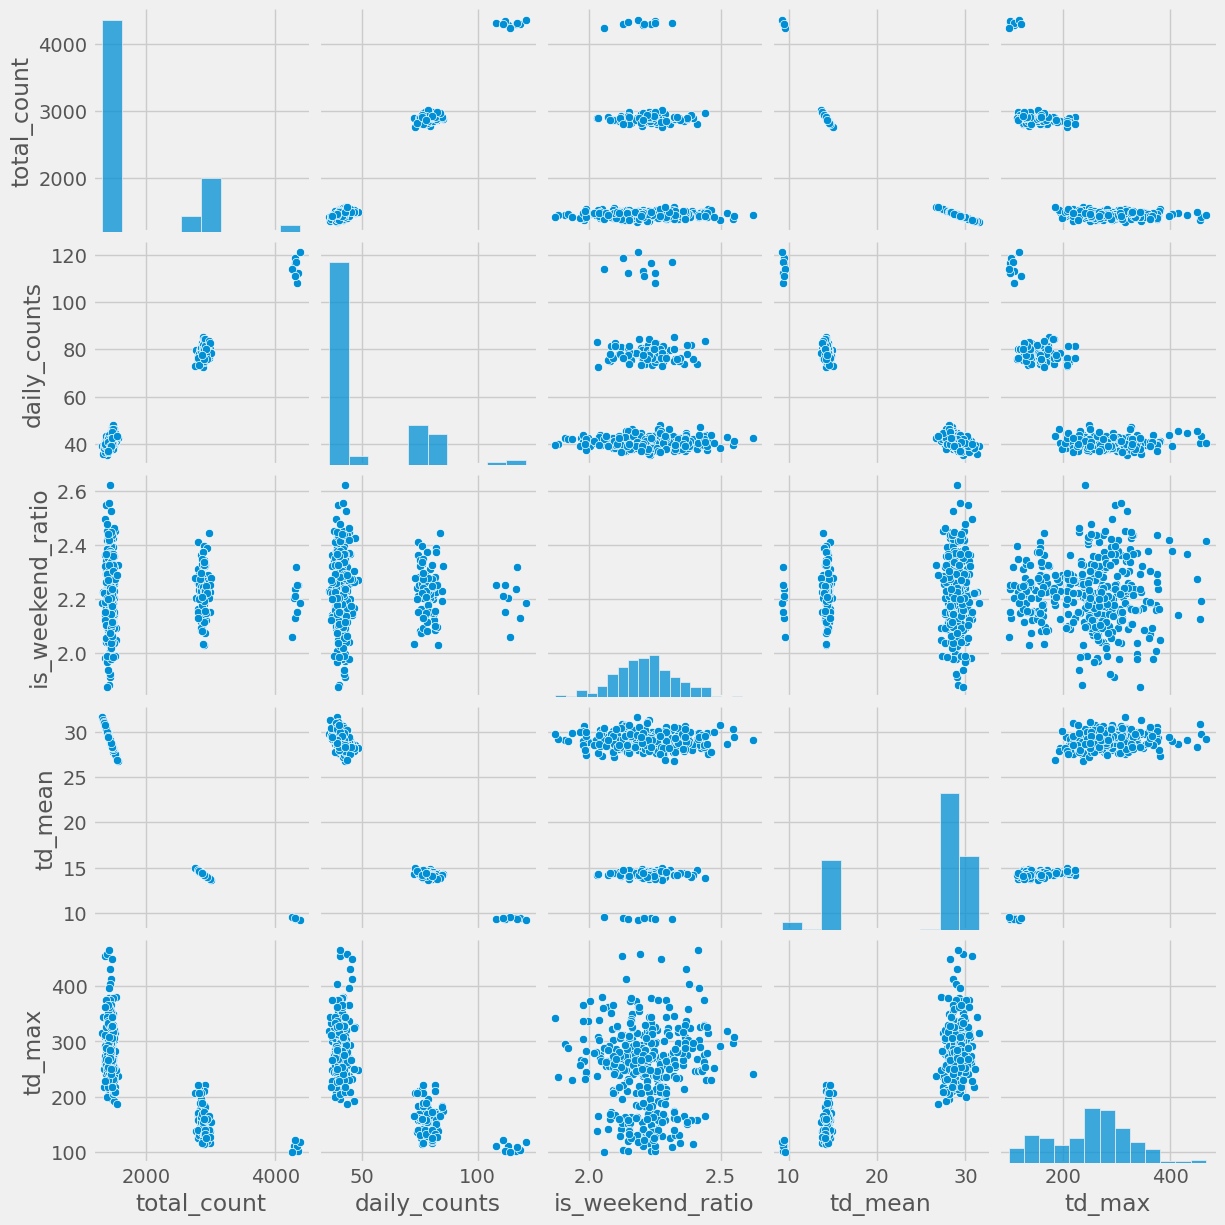

In [45]:
sns.pairplot(final_data[feature_cols])

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

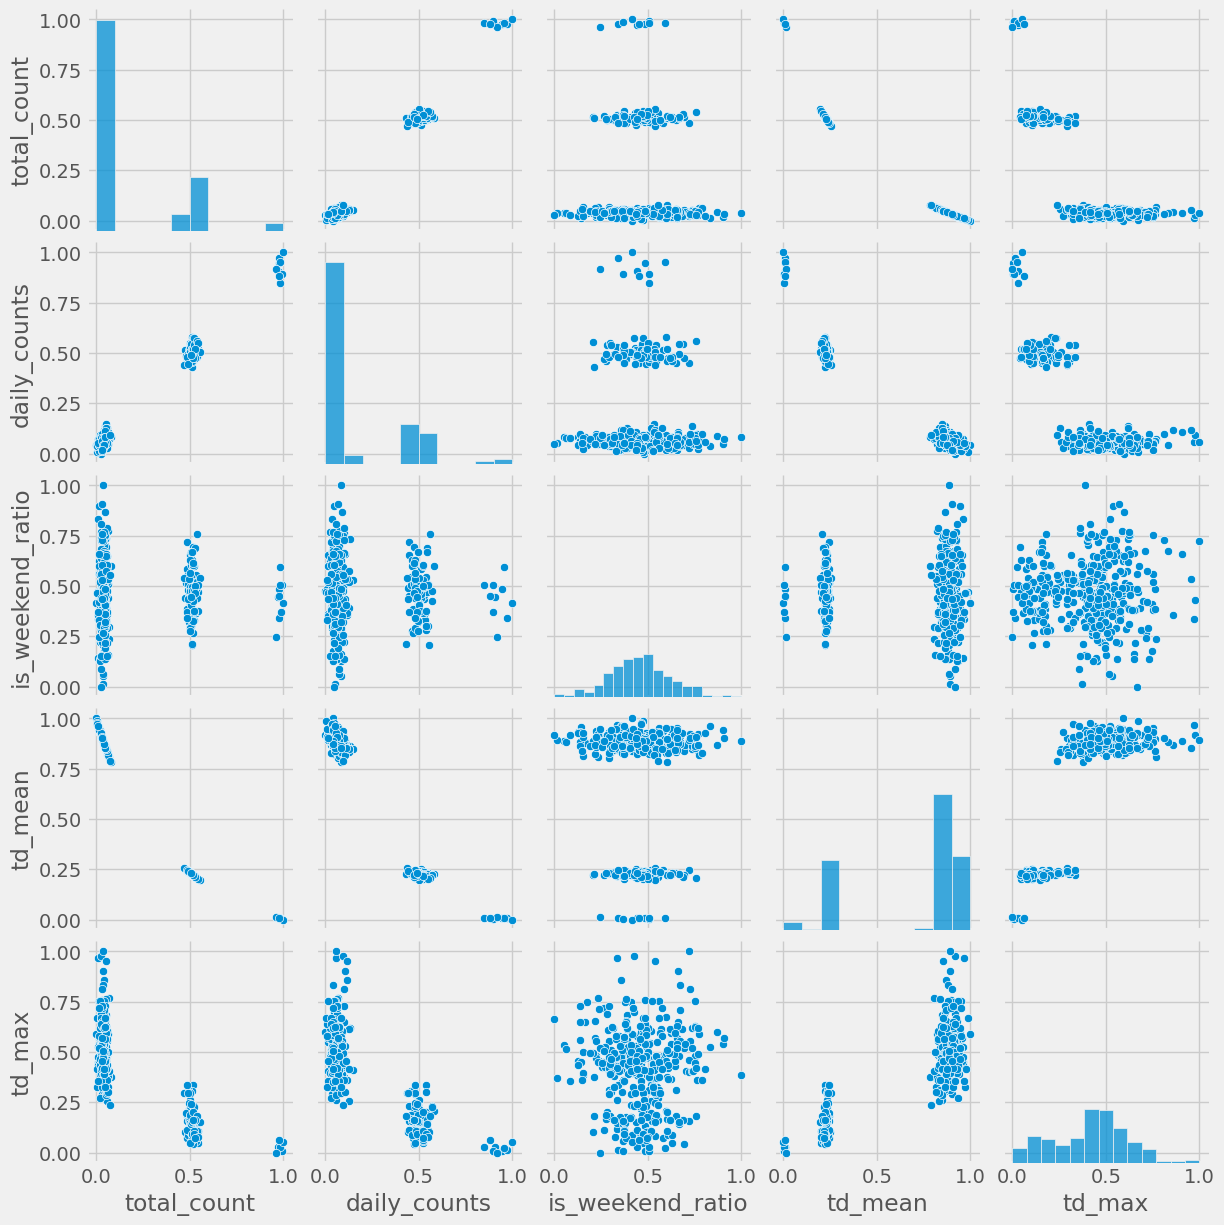

In [46]:
sns.pairplot(data_new)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

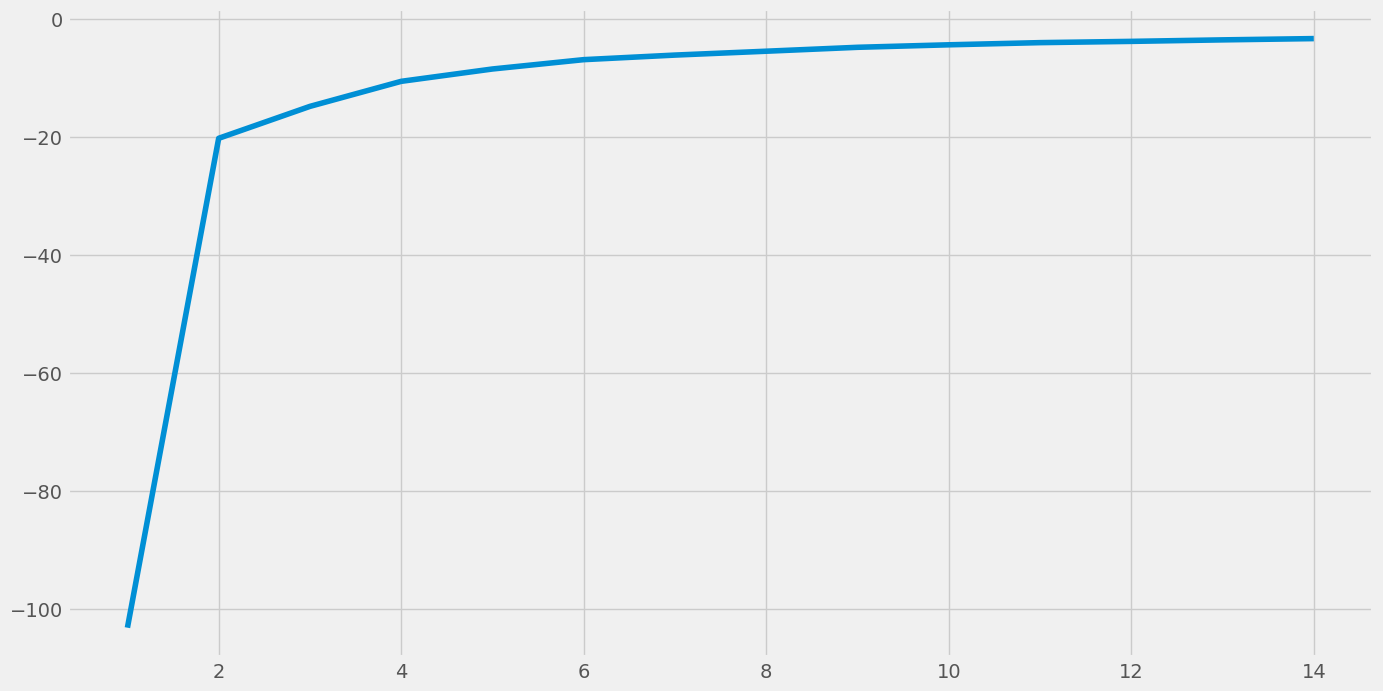

In [47]:
n_cluster = range(1, 15)
kmeans = [KMeans(n_clusters=i, random_state=RANDOM_STATE).fit(data_new) for i in n_cluster]
scores = [kmeans[i].score(data_new) for i in range(len(kmeans))]
fig, ax = plt.subplots()
ax.plot(n_cluster, scores)
plt.show()

In [48]:
cluster_model = kmeans[5]

In [49]:
final_data['cluster'] = cluster_model.predict(data_new)
final_data['cluster'].value_counts()

cluster
1    103
2     94
4     73
3     60
5     46
0     10
Name: count, dtype: int64

In [50]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300, random_state=RANDOM_STATE)

In [51]:
tsne_results = tsne.fit_transform(data_new)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 386 samples in 0.001s...
[t-SNE] Computed neighbors for 386 samples in 0.010s...
[t-SNE] Computed conditional probabilities for sample 386 / 386
[t-SNE] Mean sigma: 0.077308
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.639771
[t-SNE] KL divergence after 300 iterations: 0.340902


In [52]:
final_data['tsne-2d-one'] = tsne_results[:,0]
final_data['tsne-2d-two'] = tsne_results[:,1]

In [53]:
tsne_cluster = final_data.groupby('cluster').agg({'tsne-2d-one':'mean', 'tsne-2d-two':'mean'}).reset_index()

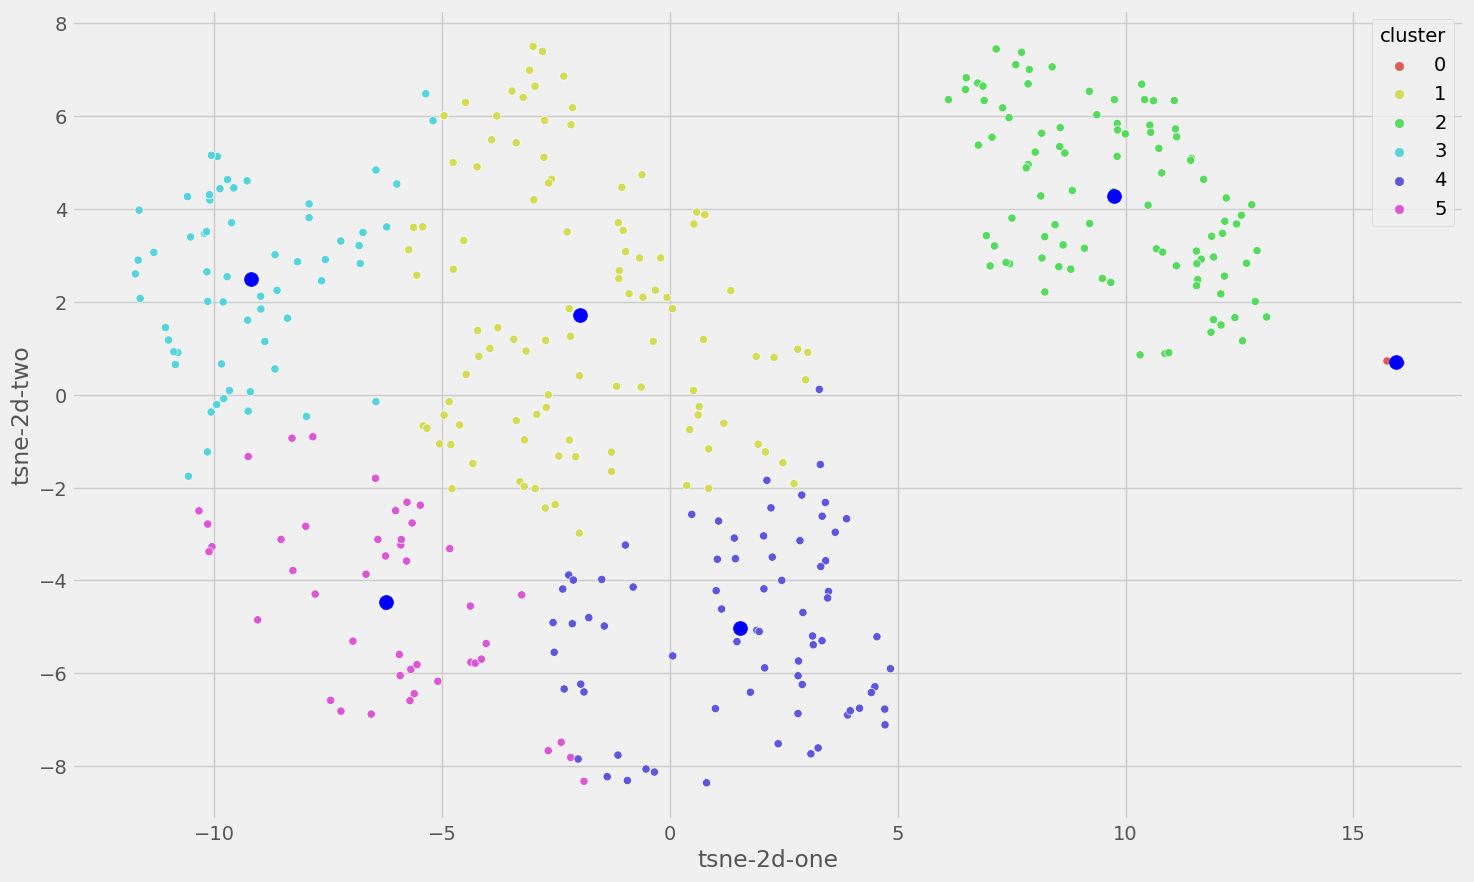

In [54]:
plt.figure(figsize=(16,10))

sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="cluster",
    palette=sns.color_palette("hls", 6),
    data=final_data,
    legend="full",
    alpha=1
)

plt.scatter(x="tsne-2d-one", y="tsne-2d-two", data=tsne_cluster, s=100, c='b')

plt.show()

In [55]:
centers = cluster_model.cluster_centers_

In [56]:
points = np.asarray(data_new)

In [57]:
total_distance = pd.Series()

In [67]:
def get_sum_square_distance(data, cluster_model):
    centers = cluster_model.cluster_centers_
    points = np.asarray(data[feature_cols])
    total_distance = pd.Series()
    for i in range(len(points)):
        distance = 0
        for j in range(len(centers)):
            a = np.linalg.norm(points[i] - centers[j])
            distance += a**2
        total_distance._set_value(i, distance)
    
    return total_distance    

In [68]:
final_data['ssd'] = get_sum_square_distance(data_new, cluster_model)

(array([12., 13., 41., 40., 39., 24., 24., 25.,  7., 12., 10.,  8.,  6.,
         5.,  5.,  5.,  8.,  7.,  5., 12., 19., 14., 10.,  9.,  7.,  1.,
         5.,  1.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,
         0.,  2.,  1.,  1.,  1.,  0.,  1.,  0.,  1.]),
 array([0.96380072, 1.01531597, 1.06683122, 1.11834647, 1.16986172,
        1.22137697, 1.27289222, 1.32440747, 1.37592272, 1.42743797,
        1.47895322, 1.53046847, 1.58198372, 1.63349897, 1.68501422,
        1.73652947, 1.78804472, 1.83955997, 1.89107522, 1.94259047,
        1.99410572, 2.04562097, 2.09713622, 2.14865147, 2.20016672,
        2.25168197, 2.30319722, 2.35471247, 2.40622772, 2.45774297,
        2.50925822, 2.5607

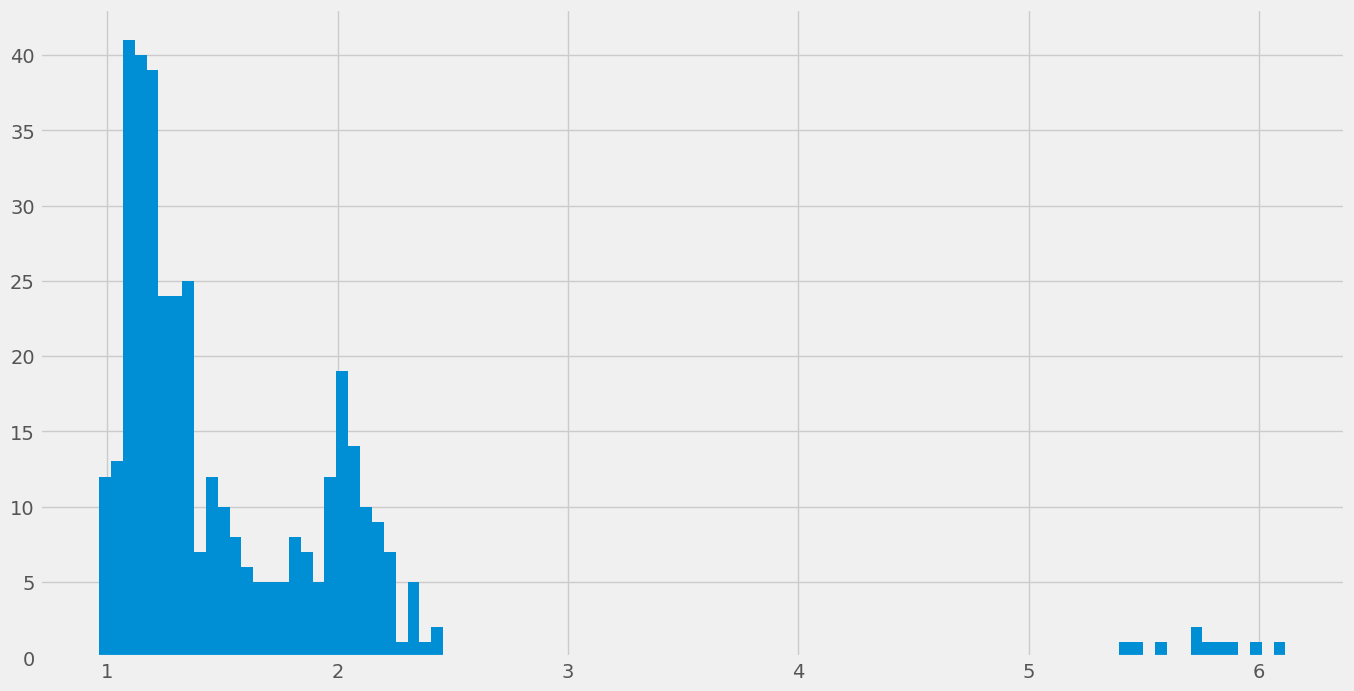

In [69]:
plt.hist(final_data['ssd'], bins=100)

In [70]:
cutoff = 6

In [71]:
final_data['anomaly_kmeans'] = (final_data['ssd'] >= cutoff).astype(int)

<Axes: xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

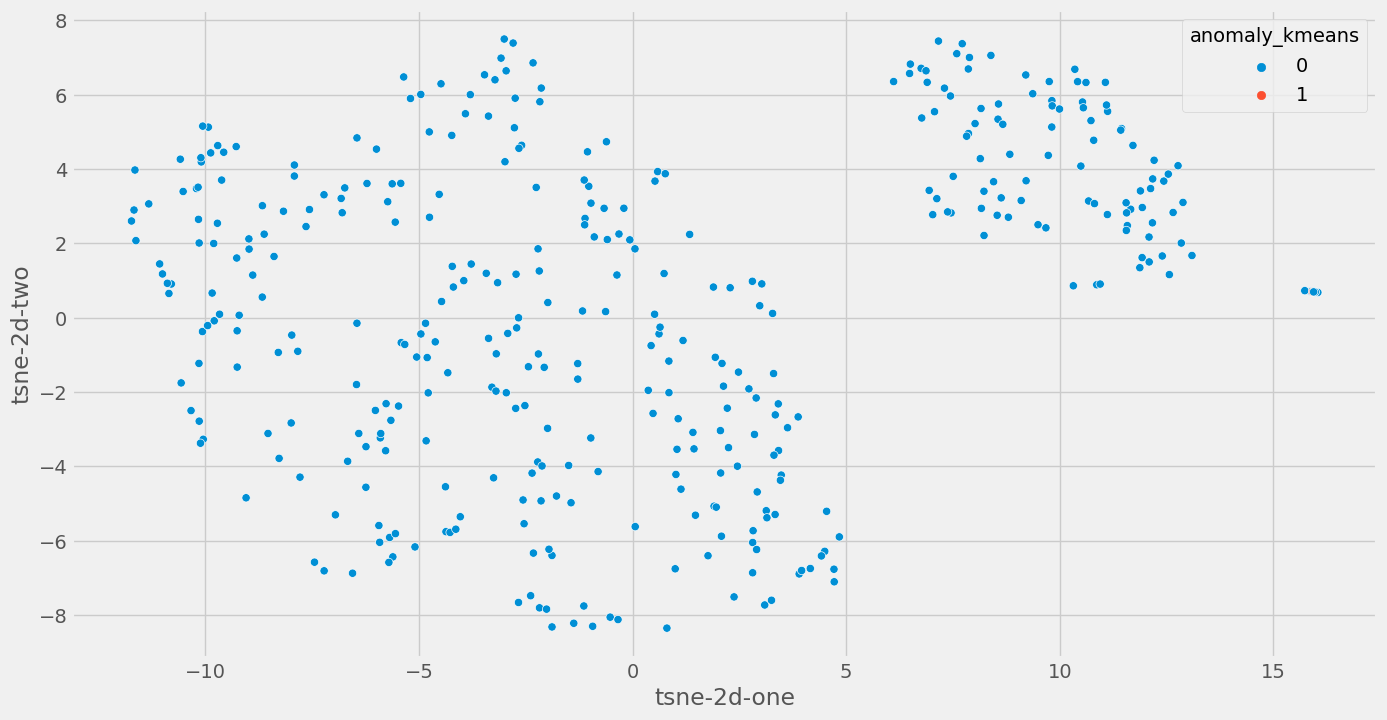

In [72]:
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="anomaly_kmeans",
#     palette=sns.color_palette("hls", 10),
    data=final_data,
    legend="full",
    alpha=1
)

In [73]:
final_data.loc[final_data['anomaly_kmeans']==1]

,ip_address,total_count,daily_counts,is_weekend_ratio,td_mean,td_max,cluster,tsne-2d-one,tsne-2d-two,ssd,anomaly_kmeans
370,10.1.2.63,4372,121.0,2.184268,9.268588,118.0,0,15.919003,0.69461,6.115326,1


# Isolated Forests

In [74]:
outlier_fraction = 0.028

In [75]:
final_data.head()

,ip_address,total_count,daily_counts,is_weekend_ratio,td_mean,td_max,cluster,tsne-2d-one,tsne-2d-two,ssd,anomaly_kmeans
0,10.1.1.1,1446,40.0,2.070064,28.999308,362.0,5,-2.176888,-7.809092,1.544461,0
1,10.1.1.100,2860,78.0,2.177778,14.427072,185.0,2,9.677166,2.418160,1.886894,0
2,10.1.1.101,1465,40.0,2.191721,28.520492,211.0,1,0.588707,3.932106,1.086970,0
3,10.1.1.106,1408,35.5,2.229358,29.771144,319.0,5,-5.903688,-3.234276,1.351651,0
4,10.1.1.109,1459,42.5,2.206593,28.711934,278.0,1,-2.667084,-0.002501,1.076658,0


In [76]:
final_data.columns

Index(['ip_address', 'total_count', 'daily_counts', 'is_weekend_ratio',
       'td_mean', 'td_max', 'cluster', 'tsne-2d-one', 'tsne-2d-two', 'ssd',
       'anomaly_kmeans'],
      dtype='object')

In [77]:
data_new.head()

,total_count,daily_counts,is_weekend_ratio,td_mean,td_max
0,0.038133,0.052632,0.264803,0.884954,0.716621
1,0.502959,0.497076,0.408397,0.231366,0.234332
2,0.044379,0.052632,0.426985,0.863479,0.305177
3,0.025641,0.000000,0.477159,0.919573,0.599455
4,0.042406,0.081871,0.446812,0.872065,0.487738


In [78]:
model =  IsolationForest(n_jobs=-1, n_estimators=200, max_features=3, random_state=RANDOM_STATE, contamination=outlier_fraction)

In [108]:
IsolationForest=model.fit(data_new)

In [80]:
# add the data to the main  
final_data['anomaly_isolated'] = pd.Series(model.predict(data_new))

In [81]:
final_data['anomaly_isolated'] = final_data['anomaly_isolated'].map( {1: 0, -1: 1} )

In [82]:
final_data['anomaly_isolated'].value_counts()

anomaly_isolated
0    375
1     11
Name: count, dtype: int64

<Axes: xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

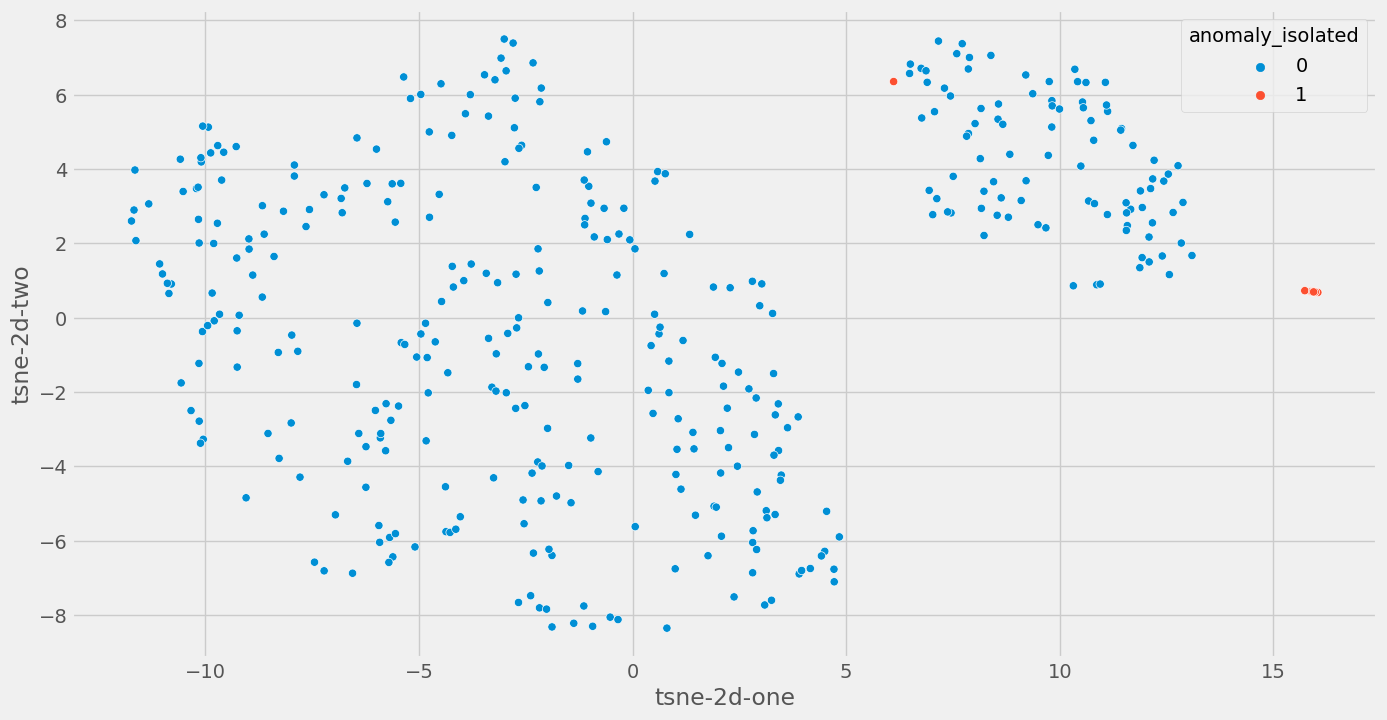

In [83]:
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="anomaly_isolated",
#     palette=sns.color_palette("hls", 10),
    data=final_data,
    legend="full",
    alpha=1
)

In [84]:
final_data.loc[final_data['anomaly_isolated']==1]

,ip_address,total_count,daily_counts,is_weekend_ratio,td_mean,td_max,cluster,tsne-2d-one,tsne-2d-two,ssd,anomaly_kmeans,anomaly_isolated
62,10.1.1.249,4301,116.5,2.236268,9.459535,101.0,0,15.959301,0.692119,5.826522,0,1
118,10.1.1.386,4300,118.5,2.127273,9.453361,104.0,0,15.864429,0.706089,5.962115,0,1
164,10.1.1.486,4317,117.0,2.315668,9.417285,108.0,0,16.042791,0.679795,5.883621,0,1
177,10.1.1.63,4339,112.0,2.148766,9.368142,101.0,0,15.889607,0.704302,5.710055,0,1
188,10.1.1.86,4293,113.0,2.203731,9.456897,110.0,0,15.936123,0.695728,5.588655,0,1
255,10.1.2.249,4353,112.0,2.250934,9.332721,102.0,0,15.974795,0.690818,5.703553,0,1
311,10.1.2.386,4326,108.0,2.250188,9.392370,110.0,0,15.982093,0.690850,5.420208,0,1
357,10.1.2.486,4251,114.0,2.056075,9.571059,99.0,0,15.737044,0.727273,5.772599,0,1
361,10.1.2.497,2973,83.5,2.440972,13.869785,165.0,2,6.112523,6.354951,2.436108,0,1
370,10.1.2.63,4372,121.0,2.184268,9.268588,118.0,0,15.919003,0.694610,6.115326,1,1


# One Class SVM

In [87]:
model =  OneClassSVM(nu=outlier_fraction, degree=2, kernel='rbf')

In [88]:
data_new_clean = data_new.loc[data_new.total_count <=data_new.total_count.quantile(1-outlier_fraction)]

In [109]:
SVM =model.fit(data_new_clean)

In [90]:
final_data['anomaly_svm'] = pd.Series(model.predict(data_new))

In [91]:
final_data['anomaly_svm'] = final_data['anomaly_svm'].map( {1: 0, -1: 1} )

In [92]:
final_data['anomaly_svm'].value_counts()

anomaly_svm
0    364
1     22
Name: count, dtype: int64

<Axes: xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

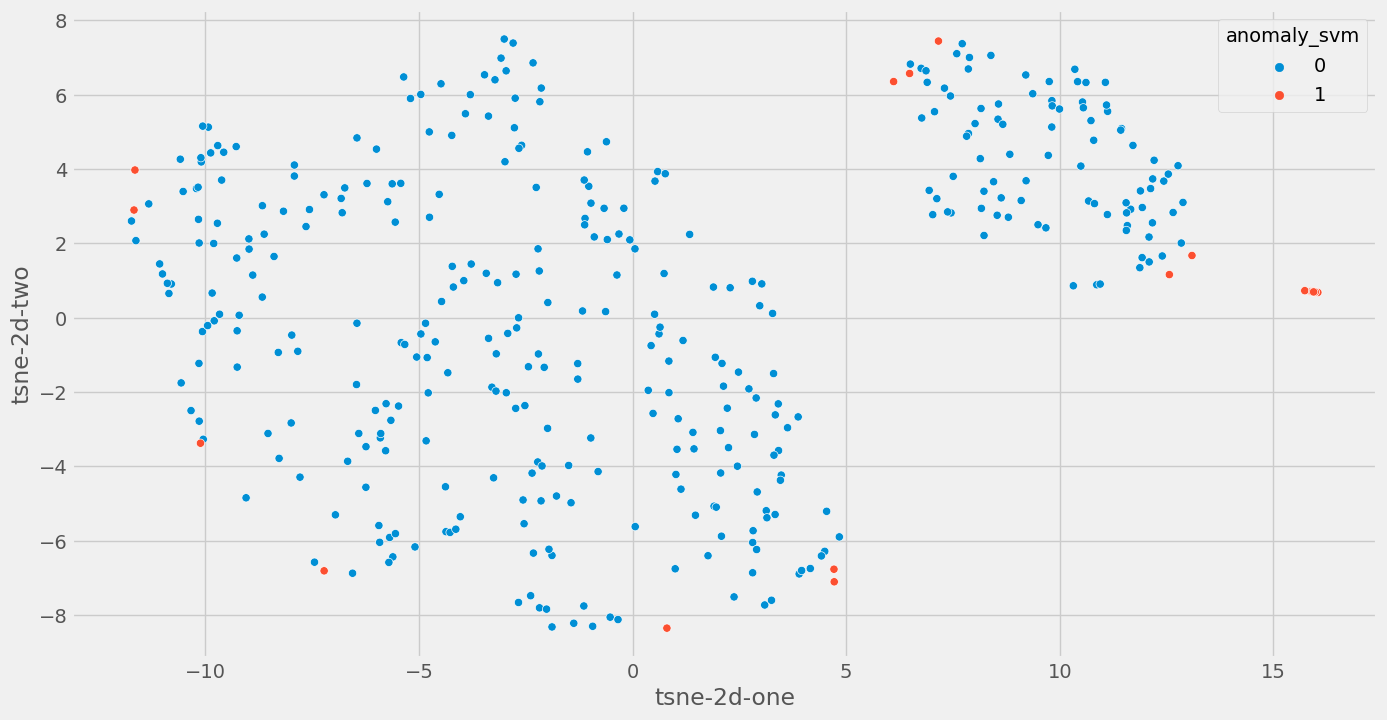

In [93]:
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="anomaly_svm",
#     palette=sns.color_palette("hls", 10),
    data=final_data,
    legend="full",
    alpha=1
)

In [94]:
final_data.loc[final_data['anomaly_svm']==1]

,ip_address,total_count,daily_counts,is_weekend_ratio,td_mean,td_max,cluster,tsne-2d-one,tsne-2d-two,ssd,anomaly_kmeans,anomaly_isolated,anomaly_svm
14,10.1.1.138,1383,39.5,2.546154,30.306078,297.0,3,-11.669203,2.897771,1.827783,0,0,1
42,10.1.1.199,1365,40.5,2.123570,30.801320,455.0,5,-7.218606,-6.813094,2.314514,0,0,1
62,10.1.1.249,4301,116.5,2.236268,9.459535,101.0,0,15.959301,0.692119,5.826522,0,1,1
70,10.1.1.264,1445,42.5,2.621554,29.042936,241.0,3,-11.647155,3.974470,1.905744,0,0,1
118,10.1.1.386,4300,118.5,2.127273,9.453361,104.0,0,15.864429,0.706089,5.962115,0,1,1
136,10.1.1.427,1438,40.0,1.881764,29.170494,235.0,4,4.721705,-7.108068,1.738465,0,0,1
164,10.1.1.486,4317,117.0,2.315668,9.417285,108.0,0,16.042791,0.679795,5.883621,0,1,1
177,10.1.1.63,4339,112.0,2.148766,9.368142,101.0,0,15.889607,0.704302,5.710055,0,1,1
188,10.1.1.86,4293,113.0,2.203731,9.456897,110.0,0,15.936123,0.695728,5.588655,0,1,1
189,10.1.1.89,2895,83.0,2.028243,14.259157,137.0,2,13.096119,1.673711,2.402661,0,0,1


# Performance of Algo

Since it is unsupervised we need to manually label the data and see the performance of the individual algos

- Criteria for manual labels is strictly based on counts as we want the algos to be robust on count anomalies

In [95]:
total_counts_condition = (final_data['total_count'] >= final_data['total_count'].quantile(0.98)) 
daily_counts_condition =  (final_data['daily_counts'] >= final_data['daily_counts'].quantile(0.98))

In [97]:
final_data['anomaly_manual'] = (total_counts_condition | daily_counts_condition).astype(int)

In [98]:
final_data.head()

,ip_address,total_count,daily_counts,is_weekend_ratio,td_mean,td_max,cluster,tsne-2d-one,tsne-2d-two,ssd,anomaly_kmeans,anomaly_isolated,anomaly_svm,anomaly_manual
0,10.1.1.1,1446,40.0,2.070064,28.999308,362.0,5,-2.176888,-7.809092,1.544461,0,0,0,0
1,10.1.1.100,2860,78.0,2.177778,14.427072,185.0,2,9.677166,2.418160,1.886894,0,0,0,0
2,10.1.1.101,1465,40.0,2.191721,28.520492,211.0,1,0.588707,3.932106,1.086970,0,0,0,0
3,10.1.1.106,1408,35.5,2.229358,29.771144,319.0,5,-5.903688,-3.234276,1.351651,0,0,0,0
4,10.1.1.109,1459,42.5,2.206593,28.711934,278.0,1,-2.667084,-0.002501,1.076658,0,0,0,0


In [99]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, confusion_matrix

In [100]:
def get_sensitivity_specificity(y_true, y_pred):
    cf = confusion_matrix(y_true, y_pred)
    sensitivity = cf[0,0]/(cf[:,0].sum())
    specificity = cf[1,1]/(cf[:,1].sum())
    return sensitivity, specificity

In [101]:
f1_iso = f1_score(final_data['anomaly_manual'],final_data['anomaly_isolated'])
acc_iso = accuracy_score(final_data['anomaly_manual'],final_data['anomaly_isolated'])
roc_iso = roc_auc_score(final_data['anomaly_manual'],final_data['anomaly_isolated'])
sen_iso, spec_iso = get_sensitivity_specificity(final_data['anomaly_manual'],final_data['anomaly_isolated'])
met_iso = {
           'f1_score': f1_iso,
           'accuracy': acc_iso,
           'roc_score': roc_iso,
           'sensitivity': sen_iso,
           'specificity': spec_iso
          }

In [102]:
f1_kmeans = f1_score(final_data['anomaly_manual'],final_data['anomaly_kmeans'])
acc_kmeans = accuracy_score(final_data['anomaly_manual'],final_data['anomaly_kmeans'])
roc_kmeans = roc_auc_score(final_data['anomaly_manual'],final_data['anomaly_kmeans'])
sen_kmeans, spec_kmeans = get_sensitivity_specificity(final_data['anomaly_manual'],final_data['anomaly_kmeans'])
met_kmeans = {
           'f1_score': f1_kmeans,
           'accuracy': acc_kmeans,
           'roc_score': roc_kmeans,
           'sensitivity': sen_kmeans,
           'specificity': spec_kmeans
          }

In [107]:
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, confusion_matrix

# Calculate metrics
f1_svm = f1_score(final_data['anomaly_manual'], final_data['anomaly_svm'])
acc_svm = accuracy_score(final_data['anomaly_manual'], final_data['anomaly_svm'])
roc_svm = roc_auc_score(final_data['anomaly_manual'], final_data['anomaly_svm'])
sen_svm, spec_svm = get_sensitivity_specificity(final_data['anomaly_manual'], final_data['anomaly_svm'])

# Calculate confusion matrix
cm = confusion_matrix(final_data['anomaly_manual'], final_data['anomaly_svm'])

# Store metrics in a dictionary
met_svm = {
    'f1_score': f1_svm,
    'accuracy': acc_svm,
    'roc_score': roc_svm,
    'sensitivity': sen_svm,
    'specificity': spec_svm,
    'confusion_matrix': cm.tolist()  # Convert to list for better readability if needed
}

# Optional: Print the confusion matrix
print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[364  12]
 [  0  10]]


In [104]:
metrics = {'isolated_forest': met_iso,
           'kmeans': met_kmeans,
           'svm': met_svm
          }

In [105]:
metrics_df = pd.DataFrame.from_dict(metrics)

In [106]:
metrics_df

,isolated_forest,kmeans,svm
f1_score,0.952381,0.181818,0.625000
accuracy,0.997409,0.976684,0.968912
roc_score,0.998670,0.550000,0.984043
sensitivity,1.000000,0.976623,1.000000
specificity,0.909091,1.000000,0.454545


In [111]:
from joblib import dump, load


In [112]:
models = {
    'svm_model': SVM,
    'IsolationForest': IsolationForest ,
    'kmeans': kmeans
}

# Save all models
for model_name, model in models.items():
    dump(model, f'{model_name}.joblib')  # or use pickle as shown above